# ドル円レート 日足 メジアン統計

In [32]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pingouin as pg
import seaborn as sns
import yfinance as yf

In [33]:
code = 'USDJPY=X'
symbol = code
ticker = yf.Ticker(symbol)

In [34]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='5y', interval='1d')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=366)
df = df0[df0.index >= dt_last - tdelta_1y]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-22 00:00:00+01:00,154.628998,154.783997,154.587006,154.639999,0,0.0,0.0
2024-04-23 00:00:00+01:00,154.813004,154.871002,154.593994,154.813004,0,0.0,0.0
2024-04-24 00:00:00+01:00,154.744003,155.130005,154.740005,154.744003,0,0.0,0.0
2024-04-25 00:00:00+01:00,155.259003,155.735992,155.259003,155.259003,0,0.0,0.0
2024-04-26 00:00:00+01:00,155.597000,157.666000,155.479004,155.597000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-14 00:00:00+01:00,143.695999,144.046997,142.264999,143.695999,0,0.0,0.0
2025-04-15 00:00:00+01:00,143.220993,143.578995,142.612000,143.220993,0,0.0,0.0
2025-04-16 00:00:00+01:00,143.181000,143.158005,142.070999,143.181000,0,0.0,0.0


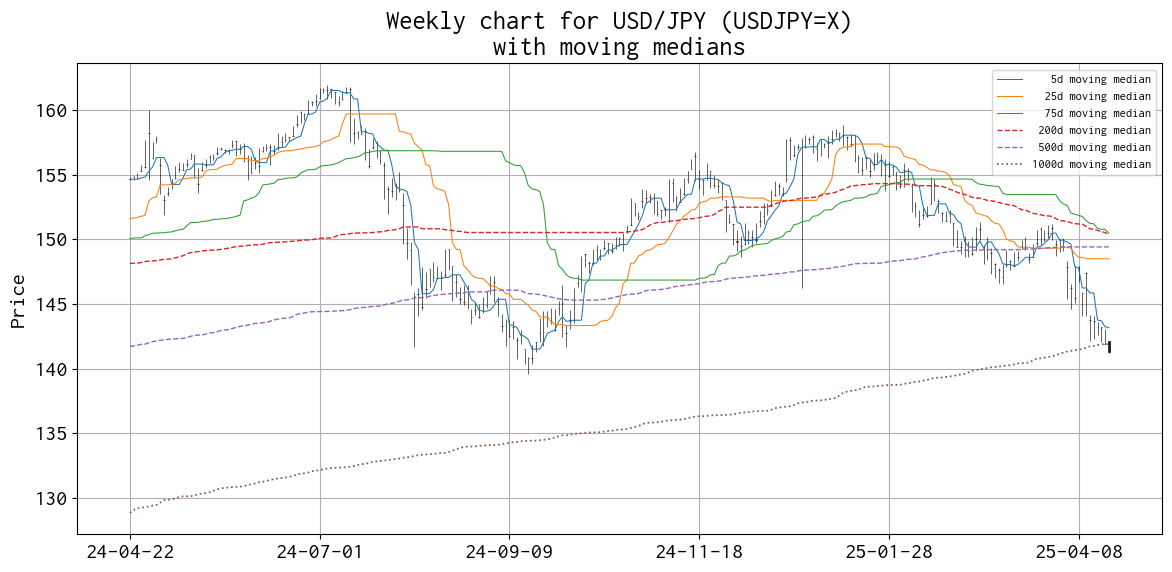

In [35]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

mm05 = df0['Close'].rolling(5).median()
mm25 = df0['Close'].rolling(25).median()
mm75 = df0['Close'].rolling(75).median()
mm200 = df0['Close'].rolling(200).median()
mm500 = df0['Close'].rolling(500).median()
mm1000 = df0['Close'].rolling(1000).median()
apds  = [
    mpf.make_addplot(mm05[df.index], width=0.75, label='   5d moving median', ax=ax),
    mpf.make_addplot(mm25[df.index], width=0.75, label='  25d moving median', ax=ax),
    mpf.make_addplot(mm75[df.index], width=0.75, label='  75d moving median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=1.00, linestyle='dashed', label=' 200d moving median', ax=ax),
    mpf.make_addplot(mm500[df.index], width=1.00, linestyle='dashed', label=' 500d moving median', ax=ax),
    mpf.make_addplot(mm1000[df.index], width=1.25, linestyle='dotted', label='1000d moving median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=False,
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nwith moving medians' % (ticker.info['longName'], symbol))

ax.legend(loc='best', fontsize=9)
ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_robust_%s.png' % code)
plt.show()

In [36]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-21 00:00:00+01:00,142.095993,142.128998,141.220993,141.263,0,0.0,0.0


In [37]:
df.tail(2)['Close']

Date
2025-04-17 00:00:00+01:00    141.927994
2025-04-21 00:00:00+01:00    141.263000
Name: Close, dtype: float64

In [38]:
df.tail(2)['Close'].diff()

Date
2025-04-17 00:00:00+01:00         NaN
2025-04-21 00:00:00+01:00   -0.664993
Name: Close, dtype: float64

## Robust Bollinger bands

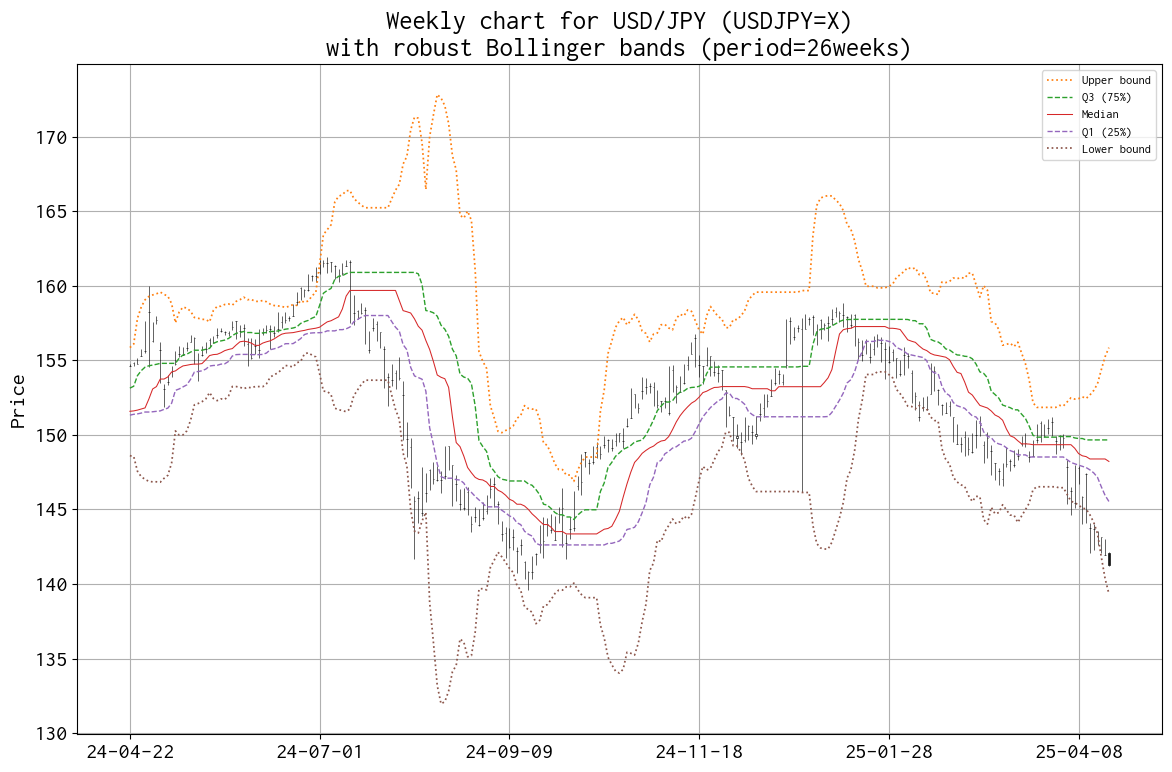

In [39]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

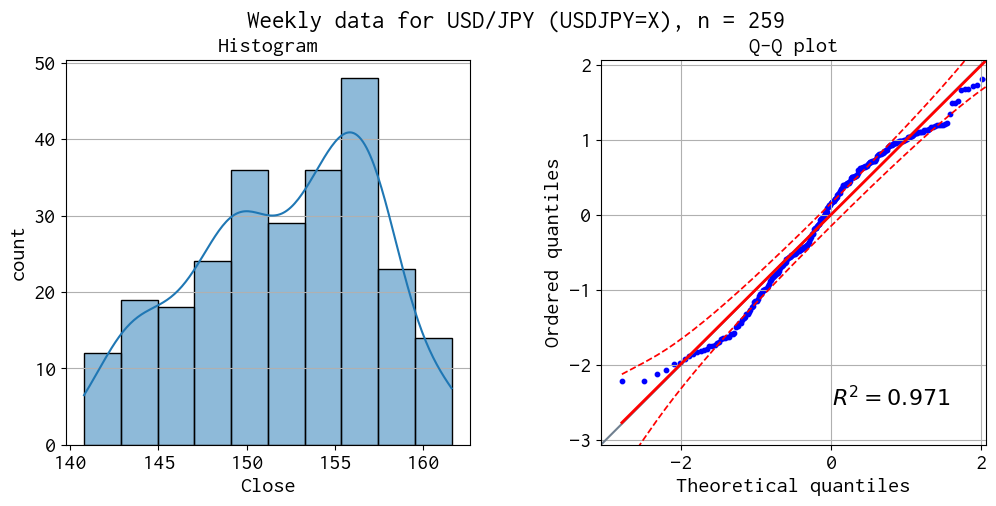

In [40]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()